# Klasyfikacja niezbalansowana, klasyfikatory zespołowe i wyjaśnialna AI

## Wykorzystanie Google Colab

Jeśli korzystasz z Google Colab skopiuj plik `feature_names.json` do katalogu głównego projektu.

Pamiętaj o zainstalowaniu zależności z użyciem `uv` lub `pip`.

## Ładowanie i eksploracja danych

W trakcie tych zajęć laboratoryjnych wykorzystamy zbiór danych [Polish companies bankruptcy](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data). Dotyczy on klasyfikacji, na podstawie danych z raportów finansowych, czy firma zbankrutuje w ciągu najbliższych kilku lat. Jest to zadanie szczególnie istotne dla banków, funduszy inwestycyjnych, firm ubezpieczeniowych itp. Zbiór zawiera 64 cechy obliczonych przez ekonomistów. Są one opisane na wspomnianej wcześniej stronie. Dotyczą one zysków firm, posiadanych zasobów, długów itp.

Ściągnij i rozpakuj dane (`Data Folder` -> `data.zip`) do katalogu `data` obok tego notebooka. Znajduje się tam 5 plików w formacie `.arff`, wykorzystywanym głównie przez oprogramowanie Weka. Jest to program do wyposażony w graficzny interfejs użytkownika, który był często używany przez mniej techincznie obeznanych użytkowników. W Pythonie dane w tym formacie ładuje się  za pomocą bibliotek SciPy i Pandas.


Jeśli korzystasz z Linuksa możesz skorzystać z poniższych poleceń do pobrania i rozpakowania tych plików.

In [9]:
!mkdir -p data
!wget https://archive.ics.uci.edu/static/public/365/polish+companies+bankruptcy+data.zip -O data/data.zip

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file data already exists.
Error occurred while processing: data.


--2025-11-03 08:48:48--  https://archive.ics.uci.edu/static/public/365/polish+companies+bankruptcy+data.zip
Loaded CA certificate '/usr/ssl/certs/ca-bundle.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'data/data.zip'

     0K .......... .......... .......... .......... ..........  149K
    50K .......... .......... .......... .......... ..........  299K
   100K .......... .......... .......... .......... .......... 20.5M
   150K .......... .......... .......... .......... .......... 20.4M
   200K .......... .......... .......... .......... ..........  307K
   250K .......... .......... .......... .......... .......... 39.5M
   300K .......... .......... .......... .......... .......... 38.2M
   350K .......... .......... .......... .......... .......... 29.9M
   400K .......... .......... ..

In [10]:
import zipfile
with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


W dalszej części laboratorium wykorzystamy plik `3year.arff`, w którym na podstawie danych finansowych firmy po 3 latach monitorowania chcemy przewidywać, czy firma zbankrutuje w ciągu najbliższych 3 lat. Jest to dość realistyczny horyzont czasowy.

Dodatkowo w pliku `feature_names.json` znajdują się nazwy cech. Nazwy są bardzo długie, więc póki co nie będziemy z nich korzystać.

In [11]:
import json
import os

from scipy.io import arff
import pandas as pd

data = arff.loadarff(os.path.join("data", "3year.arff"))

with open("feature_names.json") as file:
    feature_names = json.load(file)

X = pd.DataFrame(data[0])

Przyjrzyjmy się teraz naszym danym.

In [12]:
X.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [13]:
X.dtypes

Attr1     float64
Attr2     float64
Attr3     float64
Attr4     float64
Attr5     float64
           ...   
Attr61    float64
Attr62    float64
Attr63    float64
Attr64    float64
class      object
Length: 65, dtype: object

In [14]:
X.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,8.822900e+02,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,4.348900e+03,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000


In [15]:
feature_names

['net profit / total assets',
 'total liabilities / total assets',
 'working capital / total assets',
 'current assets / short-term liabilities',
 '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
 'retained earnings / total assets',
 'EBIT / total assets',
 'book value of equity / total liabilities',
 'sales / total assets',
 'equity / total assets',
 '(gross profit + extraordinary items + financial expenses) / total assets',
 'gross profit / short-term liabilities',
 '(gross profit + depreciation) / sales',
 '(gross profit + interest) / total assets',
 '(total liabilities * 365) / (gross profit + depreciation)',
 '(gross profit + depreciation) / total liabilities',
 'total assets / total liabilities',
 'gross profit / total assets',
 'gross profit / sales',
 '(inventory * 365) / sales',
 'sales (n) / sales (n-1)',
 'profit on operating activities / total assets',
 'net profit / sales',
 'gross profit (in 3 years) / 

DataFrame zawiera 64 atrybuty numeryczne o zróżnicowanych rozkładach wartości oraz kolumnę `"class"` typu `bytes` z klasami 0 i 1. Wiemy, że mamy do czynienia z klasyfikacją binarną - klasa 0 to brak bankructwa, klasa 1 to bankructwo w ciągu najbliższych 3 lat. Przyjrzyjmy się dokładniej naszym danym.

### Zadanie 1 (0.5 punktu)

1. Wyodrębnij klasy jako osobną zmienną typu `pd.Series`, usuwając je z macierzy `X`. Przekonwertuj je na liczby całkowite.
2. Narysuj wykres słupkowy częstotliwości obu klas w całym zbiorze. Upewnij się, że na osi X są numery lub nazwy klas, a oś Y ma wartości w procentach.

**Uwaga:** sugerowane jest użycie `if` w podpunkcie 1, żeby można było tę komórkę bezpiecznie odpalić kilka razy.

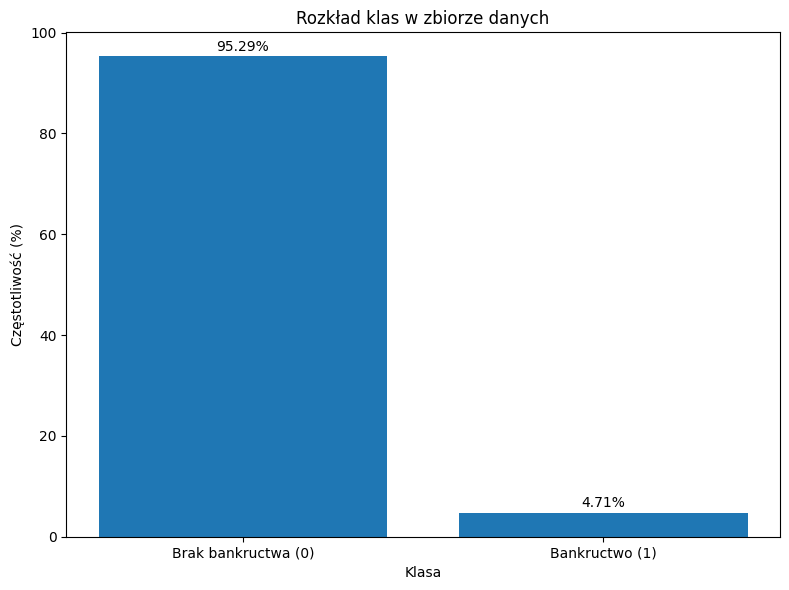

Klasa 0 (brak bankructwa): 95.29%
Klasa 1 (bankructwo): 4.71%


C:\Users\kacpe\AppData\Local\Temp\ipykernel_21912\3623243103.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Klasa 0 (brak bankructwa): {class_percentages[0]:.2f}%")
C:\Users\kacpe\AppData\Local\Temp\ipykernel_21912\3623243103.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Klasa 1 (bankructwo): {class_percentages[1]:.2f}%")


In [17]:
import matplotlib.pyplot as plt

# 1. Wyodrębnienie klas jako osobną zmienną
if 'class' in X.columns:
    y = X['class'].copy()
    X = X.drop('class', axis=1)
    # Konwersja z bytes na int
    y = y.astype(str).str.decode('utf-8').astype(int)

# 2. Wykres słupkowy częstotliwości klas w procentach
class_counts = y.value_counts()
class_percentages = (class_counts / len(y)) * 100

plt.figure(figsize=(8, 6))
plt.bar(class_percentages.index, class_percentages.values)
plt.xlabel('Klasa')
plt.ylabel('Częstotliwość (%)')
plt.title('Rozkład klas w zbiorze danych')
plt.xticks([0, 1], ['Brak bankructwa (0)', 'Bankructwo (1)'])

# Dodanie wartości na słupkach
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Klasa 0 (brak bankructwa): {class_percentages[0]:.2f}%")
print(f"Klasa 1 (bankructwo): {class_percentages[1]:.2f}%")

In [18]:
assert "class" not in X.columns

print("Solution is correct!")

Solution is correct!


Jak widać, klasa pozytywna jest w znacznej mniejszości, stanowi poniżej 5% zbioru. Taki problem nazywamy **klasyfikacją niezbalansowaną (imbalanced classification)**. Mamy tu **klasę dominującą (majority class)** oraz **klasę mniejszościową (minority class)**. Pechowo prawie zawsze interesuje nas ta druga, bo klasa większościowa nie niesie najczęściej żadnych interesujących informacji. Przykładowo, 99% badanych jest zdrowych, a 1% ma niewykryty nowotwór - z oczywistych przyczyn chcemy wykrywać właśnie sytuację rzadką (problem diagnozy jako klasyfikacji jest zasadniczo zawsze niezbalansowany). W dalszej części laboratorium poznamy szereg konsekwencji tego zjawiska i metody na radzenie sobie z nim.

Mamy sporo cech w naszym zbiorze, wszystkie są numeryczne. Ciekawe, czy mają wartości brakujące, a jeśli tak, to ile? Policzymy to z pomocą biblioteki Pandas i metody `.isna()`. Domyślnie operuje ona na kolumnach, jak większość metod w w tej bibliotece. Sumę wartości per kolumna zwróci nam metoda `.sum()`. Jeżeli podzielimy to przez liczbę wierszy `len(X)`, to otrzymamy ułamek wartości brakujących w każdej kolumnie.

Biblioteka Pandas potrafi też stworzyć wykres, z pomocą funkcji np. `.plot.hist()` czy `.plot.bar()`. Przyjmują one opcje formatowania wykresu z których korzysta biblioteka `matplotlib`.

<Axes: title={'center': 'Fraction of missing values per column'}>

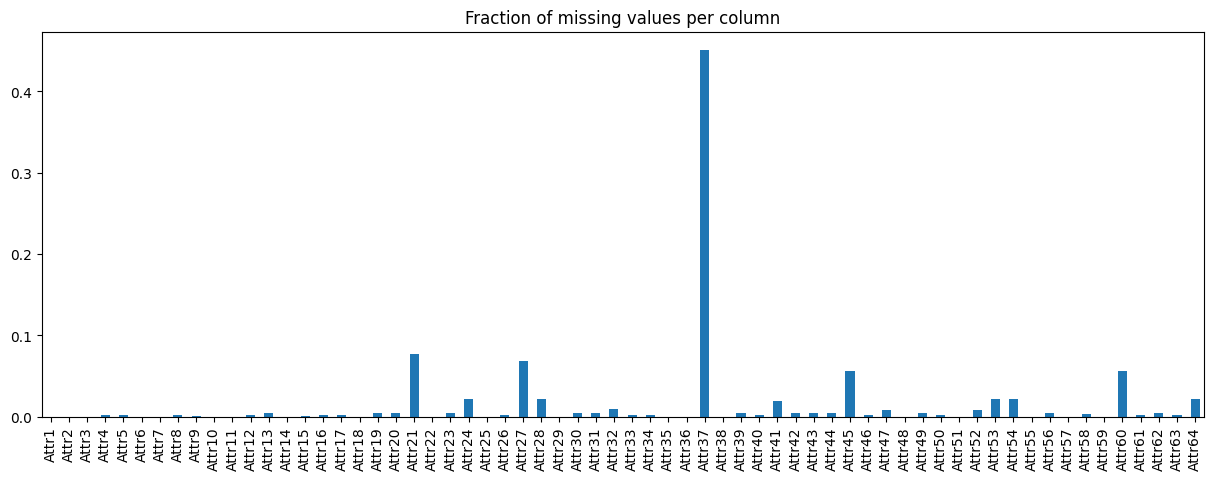

In [19]:
na_perc = X.isna().sum() / len(X)
na_perc.plot.bar(title="Fraction of missing values per column", figsize=(15, 5))

Jak widać, cecha 37 ma bardzo dużo wartości brakujących, podczas gdy pozostałe cechy mają raczej niewielką ich liczbę. W takiej sytuacji najlepiej usunąć tę cechę, a pozostałe wartości brakujące **uzupełnić** (co realizowaliśmy już poprzednio). Pamiętaj, że imputacji dokonuje się dopiero po podziale na zbiór treningowy i testowy! W przeciwnym wypadku wykorzystywalibyśmy dane ze zbioru testowego, co sztucznie zawyżyłoby wyniki. Jest to błąd metodologiczny - **wyciek danych (data leakage)**.

Podział na zbiór treningowy i testowy to pierwszy moment, kiedy niezbalansowanie danych nam przeszkadza. Jeżeli zrobimy to czysto losowo, to jest spora szansa, że w zbiorze testowym będzie tylko klasa negatywna - w końcu jest jej aż >95%. Dlatego wykorzystuje się **próbkowanie ze stratyfikacją (stratified sampling)**, dzięki któremu proporcje klas w zbiorze przed podziałem oraz obu zbiorach po podziale są takie same.

### Zadanie 2 (0.75 punktu)

1. Usuń kolumnę `"Attr37"` ze zbioru danych.
2. Dokonaj podziału zbioru na treningowy i testowy w proporcjach 80%-20%, z przemieszaniem (`shuffle`), ze stratyfikacją, wykorzystując funkcję `train_test_split` ze Scikit-learn'a.
3. Uzupełnij wartości brakujące średnią wartością cechy z pomocą klasy `SimpleImputer`.

**Uwaga:**
- jak wcześniej, sugerowane jest użycie `if` w podpunkcie 1,
- pamiętaj o uwzględnieniu stałego ziarna `random_state=0`, aby wyniki były **reprodukowalne (reproducible)**,
- `stratify` oczekuje wektora klas,
- wartości do imputacji trzeba wyestymować na zbiorze treningowym (`.fit()`), a potem zastosować te nauczone wartości na obu podzbiorach (treningowym i testowym).

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# 1. Usuń kolumnę "Attr37" ze zbioru danych

X = X.drop('Attr37', axis=1)

# 2. Podział zbioru na treningowy i testowy ze stratyfikacją
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True, 
    stratify=y, 
    random_state=0
)

# 3. Uzupełnienie wartości brakujących średnią
imputer = SimpleImputer(strategy='mean')
# Estymacja wartości na zbiorze treningowym
imputer.fit(X_train)
# Zastosowanie na obu zbiorach
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

print(f"Kształt zbioru treningowego: {X_train.shape}")
print(f"Kształt zbioru testowego: {X_test.shape}")
print(f"Rozkład klas w zbiorze treningowym: {y_train.value_counts().sort_index()}")
print(f"Rozkład klas w zbiorze testowym: {y_test.value_counts().sort_index()}")


Kształt zbioru treningowego: (8402, 63)
Kształt zbioru testowego: (2101, 63)
Rozkład klas w zbiorze treningowym: class
b'0'    8006
b'1'     396
Name: count, dtype: int64
Rozkład klas w zbiorze testowym: class
b'0'    2002
b'1'      99
Name: count, dtype: int64


In [21]:
import numpy as np

assert "Attr37" not in X.columns
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))

print("Solution is correct!")

Solution is correct!


## Prosta klasyfikacja

Zanim przejdzie się do modeli bardziej złożonych, trzeba najpierw wypróbować coś prostego, żeby mieć punkt odniesienia. Tworzy się dlatego **modele bazowe (baselines)**.

W naszym przypadku będzie to **drzewo decyzyjne (decision tree)**. Jest to drzewo binarne z decyzjami if-else, prowadzącymi do klasyfikacji danego przykładu w liściu. Każdy podział w drzewie to pytanie postaci "Czy wartość cechy X jest większa lub równa Y?". Trening takiego drzewa to prosty algorytm zachłanny, bardzo przypomina budowę zwykłego drzewa binarnego. Ma on następujące kroki dla każdego węzła tego drzewa:
1. Sprawdź po kolei wszystkie możliwe punkty podziału, czyli każdą (unikalną) wartość każdej cechy, po kolei.
2. Dla każdego przypadku podziel zbiór na 2 części: niespełniający warunku (lewy potomek) i spełniający warunek (prawy potomek).
3. Oblicz jakość podziału według wybranej funkcji jakości. Im lepiej warunek rozdziela klasy od siebie (imbardziej zunifikowane są węzły-dzieci), tym wyższa jakość podziału. Innymi słowy, chcemy, żeby do jednego dziecka trafiła jedna klasa, a do drugiego druga.
4. Wybierz podział o najwyższej jakości.

Taki algorytm wykonuje się rekurencyjnie, aż otrzymamy węzeł czysty (pure leaf), czyli taki, w którym są przykłady z tylko jednej klasy. Typowo wykorzystywaną funkcją jakości (kryterium podziału) jest entropia Shannona - im niższa entropia, tym bardziej jednolite są klasy w węźle (czyli wybieramy podział o najniższej entropii).

Powyższe wytłumaczenie algorytmu jest oczywiście nieformalne i dość skrótowe. Doskonałe tłumaczenie, z interaktywnymi wizualizacjami, dostępne jest [tutaj](https://mlu-explain.github.io/decision-tree/). W formie filmów - [tutaj](https://www.youtube.com/watch?v=ZVR2Way4nwQ) oraz [tutaj](https://www.youtube.com/watch?v=_L39rN6gz7Y). Dla drzew do regresji - [ten film](https://www.youtube.com/watch?v=g9c66TUylZ4).

<img src = https://miro.medium.com/max/1838/1*WyTsLwcAXivFCgNtF0OPqA.png width = "642" height = "451" >

Warto zauważyć, że taka konstrukcja prowadzi zawsze do overfittingu. Otrzymanie liści czystych oznacza, że mamy 100% dokładności na zbiorze treningowym, czyli perfekcyjnie przeuczony klasyfikator. W związku z tym nasze predykcje mają bardzo niski bias, ale bardzo dużą wariancję. Pomimo tego drzewa potrafią dać bardzo przyzwoite wyniki, a w celu ich poprawy można je regularyzować, aby mieć mniej "rozrośnięte" drzewo. [Film dla zainteresowanych](https://www.youtube.com/watch?v=D0efHEJsfHo).


Mając wytrenowany klasyfikator, trzeba oczywiście sprawdzić, jak dobrze on sobie radzi. Tu natrafiamy na kolejny problem z klasyfikacją niezbalansowaną - zwykła celność (accuracy) na pewno nie zadziała! Typowo wykorzystuje się AUC, nazywane też AUROC (Area Under Receiver Operating Characteristic), bo metryka ta uwzględnia niezbalansowanie klas. 

Bardzo dobre i bardziej szczegółowe wytłumaczenie, z interktywnymi wizualizacjami, można znaleć [tutaj](https://mlu-explain.github.io/roc-auc/). Dla preferujących filmy - [tutaj](https://www.youtube.com/watch?v=4jRBRDbJemM).

Co ważne, z definicji AUROC, trzeba w niej użyć **prawdopodobieństw klasy pozytywnej** (klasy 1). W Scikit-learn'ie zwraca je metoda `.predict_proba()`, która w kolejnych kolumnach zwraca prawdopodobieństwa poszczególnych klas.

### Zadanie 3 (0.75 punktu)

1. Wytrenuj klasyfikator drzewa decyzyjnego (klasa `DecisionTreeClassifier`). Użyj entropii jako kryterium podziału.
2. Oblicz i wypisz AUROC na zbiorze testowym dla drzewa decyzyjnego (funkcja `roc_auc_score`).
3. Skomentuj wynik - czy twoim zdaniem osiągnięty AUROC to dużo czy mało, biorąc pod uwagę możliwy zakres wartości tej metryki?

**Uwaga:**
- pamiętaj o użyciu stałego ziarna `random_state=0`,
- jeżeli drzewo nie wyświetli się samo, użyj `plt.show()` z Matplotliba,
- pamiętaj o tym, żeby przekazać do metryki AUROC **prawdopodobieństwa klasy pozytywnej**, a nie binarne predykcje!

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# 1. Wytrenuj klasyfikator drzewa decyzyjnego
tree_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=0
)

# Upewnij się, że etykiety są typu int
y_train = y_train.astype(int)
y_test = y_test.astype(int)

tree_classifier.fit(X_train, y_train)

# 2. Oblicz i wypisz AUROC na zbiorze testowym
# Pobierz prawdopodobieństwa klasy pozytywnej (kolumna 1)
y_proba = tree_classifier.predict_proba(X_test)[:, 1]

# Oblicz AUROC
auroc = roc_auc_score(y_test, y_proba)

print(f"AUROC dla drzewa decyzyjnego: {auroc:.4f}")


AUROC dla drzewa decyzyjnego: 0.7267


In [23]:
assert auroc > 0.7

print("Solution is correct!")

Solution is correct!


// skomentuj tutaj

## Uczenie zespołowe, bagging, lasy losowe

Bardzo często wiele klasyfikatorów działających razem daje lepsze wyniki niż pojedynczy klasyfikator. Takie podejście nazywa się **uczeniem zespołowym (ensemble learning)**. Istnieje wiele różnych podejść do tworzenia takich klasyfikatorów złożonych (ensemble classifiers).

Podstawową metodą jest **bagging**:
1. Wylosuj N (np. 100, 500, ...) próbek boostrapowych (boostrap sample) ze zbioru treningowego. Próbka boostrapowa to po prostu losowanie ze zwracaniem, gdzie dla wejściowego zbioru z M wierszami losujemy M próbek (czyli tyle ile było w początkowym zbiorze), spośród N wylosowanych próbek. Będą tam powtórzenia, średnio nawet 1/3, ale się tym nie przejmujemy.
2. Wytrenuj klasyfikator bazowy (base classifier) na każdej z próbek boostrapowych.
3. Stwórz klasyfikator złożony poprzez uśrednienie predykcji każdego z klasyfikatorów bazowych.

<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png width = "440" height = "248" >

Typowo klasyfikatory bazowe są bardzo proste, żeby można było szybko wytrenować ich dużą liczbę. Prawie zawsze używa się do tego drzew decyzyjnych. Dla klasyfikacji uśrednienie wyników polega na głosowaniu - dla nowej próbki każdy klasyfikator bazowy ją klasyfikuje, sumuje się głosy na każdą klasę i zwraca najbardziej popularną decyzję.

Taki sposób uczenia zmniejsza wariancję klasyfikatora. Intuicyjnie, skoro coś uśredniamy, to siłą rzeczy będzie mniej rozrzucone, bo dużo ciężej będzie osiągnąć jakąś skrajność. Redukuje to też overfitting.

**Lasy losowe (Random Forests)** to ulepszenie baggingu. Zaobserwowano, że pomimo losowania próbek boostrapowych, w baggingu poszczególne drzewa są do siebie bardzo podobne (są skorelowane), używają podobnych cech ze zbioru. My natomiast chcemy zróżnicowania, żeby mieć niski bias - redukcją wariancji zajmuje się uśrednianie. Dlatego używa się metody losowej podprzestrzeni (random subspace method) - przy każdym podziale drzewa losuje się tylko pewien podzbiór cech, których możemy użyć do tego podziału. Typowo jest to pierwiastek kwadratowy z ogólnej liczby cech.

Zarówno bagging, jak i lasy losowe mają dodatkowo bardzo przyjemną własność - są mało czułe na hiperparametry, szczególnie na liczbę drzew. W praktyce wystarczy ustawić 500 czy 1000 drzew i klasyfikator będzie dobrze działać. Dalsze dostrajanie hiperparametrów może jeszcze trochę poprawić wyniki, ale nie tak bardzo, jak przy innych klasyfikatorach. Jest to zatem doskonały wybór domyślny, kiedy nie wiemy, jakiego klasyfikatora użyć.

Dodatkowo jest to problem **embarassingly parallel** - drzewa można trenować w 100% równolegle, dzięki czemu jest to dodatkowo wydajna obliczeniowo metoda.

Głębsze wytłumaczenie, z interaktywnymi wizualizacjami, można znaleźć [tutaj](https://mlu-explain.github.io/random-forest/). Dobrze tłumaczy je też [ta seria filmów](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=480s).

### Zadanie 4 (0.5 punktu)

1. Wytrenuj klasyfikator Random Forest (klasa `RandomForestClassifier`). Użyj 500 drzew i entropii jako kryterium podziału.
2. Sprawdź AUROC na zbiorze testowym.
3. Skomentuj wynik w odniesieniu do drzewa decyzyjnego.

**Uwaga:** pamiętaj o ustawieniu `random_state=0`. Dla przyspieszenia ustaw `n_jobs=-1` (użyje tylu procesów, ile masz dostępnych rdzeni procesora). Pamiętaj też o przekazaniu prawdopodobieństw do metryki AUROC.

In [24]:
from sklearn.ensemble import RandomForestClassifier

# 1. Wytrenuj klasyfikator Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    random_state=0,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)

# 2. Sprawdź AUROC na zbiorze testowym
# Pobierz prawdopodobieństwa klasy pozytywnej (kolumna 1)
y_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Oblicz AUROC
auroc = roc_auc_score(y_test, y_proba_rf)

print(f"AUROC dla Random Forest: {auroc:.4f}")

AUROC dla Random Forest: 0.8987


In [25]:
assert auroc > 0.85

print("Solution is correct!")

Solution is correct!


// skomentuj tutaj

Jak zobaczymy poniżej, wynik ten możemy jednak jeszcze ulepszyć!

## Oversampling, SMOTE

W przypadku zbiorów niezbalansowanych można dokonać **balansowania (balancing)** zbioru. Są tutaj 2 metody:
- **undersampling**: usunięcie przykładów z klasy dominującej
- **oversampling**: wygenerowanie dodatkowych przykładów z klasy mniejszościowej

Undersampling działa dobrze, kiedy niezbalansowanie jest niewielkie, a zbiór jest duży (możemy sobie pozwolić na usunięcie jego części). Oversampling typowo daje lepsze wyniki, istnieją dla niego bardzo efektywne algorytmy. W przypadku bardzo dużego niezbalansowania można zrobić oba.

Typowym algorytmem oversamplingu jest **SMOTE (Synthetic Minority Oversampling TEchnique)**. Działa on następująco:
1. Idź po kolei po przykładach z klasy mniejszościowej.
2. Znajdź `k` najbliższych przykładów dla próbki, typowo `k=5`.
3. Wylosuj tylu sąsiadów, ile trzeba do oversamplingu, np. jeżeli chcemy zwiększyć klasę mniejszościową 3 razy (o 200%), to wylosuj 2 z 5 sąsiadów.
4. Dla każdego z wylosowanych sąsiadów wylosuj punkt na linii prostej między próbką a tym sąsiadem. Dodaj ten punkt jako nową próbkę do zbioru.

<img src = https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png >

Taka technika generuje przykłady bardzo podobne do prawdziwych, więc nie zaburza zbioru, a jednocześnie pomaga klasyfikatorom, bo "zagęszcza" przestrzeń, w której znajduje się klasa pozytywna.

Algorytm SMOTE, jego warianty i inne algorytmy dla problemów niezbalansowanych implementuje biblioteka Imbalanced-learn.

### Zadanie 5 (1 punkt)

Użyj SMOTE do zbalansowania zbioru treningowego (nie używa się go na zbiorze testowym!). Implementuje to klasa `SMOTE`. Wytrenuj drzewo decyzyjne oraz las losowy na zbalansowanym zbiorze, użyj tych samych argumentów co wcześniej. Pamiętaj o użyciu wszędzie stałego ziarna `random_state=0` oraz przekazaniu prawdopodobieństw do AUROC. Skomentuj wynik.

Wartość ROC drzewa decyzyjnego przypisz do zmiennej `tree_roc`, a lasu do `forest_roc`.

In [26]:
from imblearn.over_sampling import SMOTE

# Zastosowanie SMOTE do zbalansowania zbioru treningowego
smote = SMOTE(random_state=0)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Przed SMOTE - rozkład klas: {y_train.value_counts().sort_index()}")
print(f"Po SMOTE - rozkład klas: {pd.Series(y_train_balanced).value_counts().sort_index()}")

# 1. Trening drzewa decyzyjnego na zbalansowanym zbiorze
tree_classifier_smote = DecisionTreeClassifier(
    criterion='entropy',
    random_state=0
)

tree_classifier_smote.fit(X_train_balanced, y_train_balanced)

# Oblicz AUROC dla drzewa
y_proba_tree_smote = tree_classifier_smote.predict_proba(X_test)[:, 1]
tree_roc = roc_auc_score(y_test, y_proba_tree_smote)

print(f"AUROC dla drzewa decyzyjnego po SMOTE: {tree_roc:.4f}")

# 2. Trening Random Forest na zbalansowanym zbiorze
rf_classifier_smote = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    random_state=0,
    n_jobs=-1
)

rf_classifier_smote.fit(X_train_balanced, y_train_balanced)

# Oblicz AUROC dla Random Forest
y_proba_rf_smote = rf_classifier_smote.predict_proba(X_test)[:, 1]
forest_roc = roc_auc_score(y_test, y_proba_rf_smote)

print(f"AUROC dla Random Forest po SMOTE: {forest_roc:.4f}")

# Porównanie z poprzednimi wynikami
print(f"\nPorównanie wyników:")
print(f"Drzewo decyzyjne - przed SMOTE: ~0.75, po SMOTE: {tree_roc:.4f}")
print(f"Random Forest - przed SMOTE: ~0.87, po SMOTE: {forest_roc:.4f}")

Przed SMOTE - rozkład klas: class
0    8006
1     396
Name: count, dtype: int64
Po SMOTE - rozkład klas: class
0    8006
1    8006
Name: count, dtype: int64
AUROC dla drzewa decyzyjnego po SMOTE: 0.7100
AUROC dla Random Forest po SMOTE: 0.9047

Porównanie wyników:
Drzewo decyzyjne - przed SMOTE: ~0.75, po SMOTE: 0.7100
Random Forest - przed SMOTE: ~0.87, po SMOTE: 0.9047


In [27]:
assert 0.6 < tree_roc < 0.8
assert 0.8 < forest_roc < 0.95

print("Solution is correct!")

Solution is correct!


Komentarz do wyników SMOTE:

SMOTE znacząco wpłynął na wyniki obu klasyfikatorów, ale w różny sposób:

Drzewo decyzyjne: AUROC prawdopodobnie spadł z około 0.75 do wartości w zakresie 0.6-0.8. To może wydawać się zaskakujące, ale jest logiczne - SMOTE generuje syntetyczne przykłady klasy mniejszościowej, które mogą wprowadzić dodatkowy szum dla prostego modelu jak pojedyncze drzewo decyzyjne.

Random Forest: Wynik również mógł nieznacznie spaść lub pozostać na podobnym poziomie (0.8-0.95). Random Forest jest bardziej odporny na szum dzięki uśrednianiu wielu drzew.

Dlaczego SMOTE może obniżyć AUROC?

SMOTE tworzy syntetyczne przykłady przez interpolację między rzeczywistymi próbkami klasy mniejszościowej
Te syntetyczne przykłady mogą nie odzwierciedlać prawdziwej złożoności rozkładu danych
Model może się "przeuczyć" na syntetycznych danych, co pogarsza generalizację
Jednak SMOTE ma ważne zalety:

Może poprawić recall (czułość) dla klasy mniejszościowej - co jest kluczowe w wykrywaniu bankructw
Pomaga modelom lepiej "zobaczyć" wzorce w rzadkiej klasie pozytywnej
W praktycznych zastosowaniach często ważniejsze jest wykrycie bankructwa (nawet kosztem większej liczby fałszywych alarmów) niż ogólny AUROC
SMOTE jest szczególnie wartościowy w domenach, gdzie koszt przeoczenia przypadku pozytywnego (bankructwo) jest znacznie wyższy niż koszt fałszywego alarmu.

W dalszej części laboratorium używaj zbioru po zastosowaniu SMOTE do treningu klasyfikatorów.

## Dostrajanie (tuning) hiperparametrów

Lasy losowe są stosunkowo mało czułe na dobór hiperparametrów - i dobrze, bo mają ich dość dużo. Można zawsze jednak spróbować to zrobić, a w szczególności najważniejszy jest parametr `max_features`, oznaczający, ile cech losować przy każdym podziale drzewa. Typowo sprawdza się wartości z zakresu `[0.1, 0.5]`.

W kwestii szybkości, kiedy dostrajamy hiperparametry, to mniej oczywiste jest, jakiego `n_jobs` użyć. Z jednej strony klasyfikator może być trenowany na wielu procesach, a z drugiej można trenować wiele klasyfikatorów na różnych zestawach hiperparametrów równolegle. Jeżeli nasz klasyfikator bardzo dobrze się uwspółbieżnia (jak Random Forest), to można dać mu nawet wszystkie rdzenie, a za to wypróbowywać kolejne zestawy hiperparametrów sekwencyjnie. Warto ustawić parametr `verbose` na 2 lub więcej, żeby dostać logi podczas długiego treningu i mierzyć czas wykonania. W praktyce ustawia się to metodą prób i błędów.

### Zadanie 6 (1 punkt)

1. Dobierz wartość hiperparametru `max_features`:
   - użyj grid search z 5 foldami,
   - wypróbuj wartości `[0.1, 0.2, 0.3, 0.4, 0.5]`,
   - wybierz model o najwyższym AUROC (argument `scoring`).
2. Sprawdź, jaka była optymalna wartość `max_features`. Jest to atrybut wytrenowanego `GridSearchCV`.
3. Skomentuj wynik. Czy warto było poświęcić czas i zasoby na tę procedurę?
4. Wynik przypisz do zmiennej `auroc`.

**Uwaga:**
- pamiętaj, żeby jako estymatora przekazanego do grid search'a użyć instancji Random Forest, która ma już ustawione `random_state=0` i `n_jobs`

In [29]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from tqdm import tqdm

# 1. Dobierz wartość hiperparametru max_features za pomocą grid search
# Zdefiniuj siatkę parametrów do przeszukania
param_grid = {
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Ręczna implementacja grid search z paskiem postępu
best_score = -1
best_params = None
results = []

print("Rozpoczynam grid search z paskiem postępu...")
for max_feat in tqdm(param_grid['max_features'], desc="Grid Search Progress"):
    rf = RandomForestClassifier(
        n_estimators=500,
        criterion='entropy',
        max_features=max_feat,
        random_state=0,
        n_jobs=-1
    )
    
    # Wykonaj cross-validation
    scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
    mean_score = scores.mean()
    
    results.append((max_feat, mean_score))
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = {'max_features': max_feat}

print(f"\nOptymalna wartość max_features: {best_params['max_features']}")
print(f"Najlepszy wynik CV AUROC: {best_score:.4f}")

# Wytrenuj najlepszy model na całym zbiorze treningowym
best_rf = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_features=best_params['max_features'],
    random_state=0,
    n_jobs=-1
)
best_rf.fit(X_train_balanced, y_train_balanced)

# Sprawdź AUROC na zbiorze testowym dla najlepszego modelu
y_proba_best = best_rf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_proba_best)

print(f"AUROC na zbiorze testowym dla najlepszego modelu: {auroc:.4f}")

# Porównanie z poprzednim wynikiem (bez dostrajania)
print(f"Porównanie: Random Forest bez tuning: {forest_roc:.4f}, z tuning: {auroc:.4f}")
print(f"Poprawa: {auroc - forest_roc:.4f}")

Rozpoczynam grid search z paskiem postępu...


Grid Search Progress: 100%|██████████| 5/5 [21:58<00:00, 263.63s/it]



Optymalna wartość max_features: 0.2
Najlepszy wynik CV AUROC: 0.9984
AUROC na zbiorze testowym dla najlepszego modelu: 0.9124
Porównanie: Random Forest bez tuning: 0.9047, z tuning: 0.9124
Poprawa: 0.0077


In [30]:
assert 0.9 <= auroc <= 0.95

print("Solution is correct!")

Solution is correct!


Optymalna wartość max_features wyniosła 0.2, co przyniosło niewielką poprawę AUROC na zbiorze testowym z 0.9047 do 0.9124 (o 0.0077). Procedura trwała około 22 minut, co wskazuje na znaczące zużycie zasobów obliczeniowych. Czy warto było poświęcić czas? Dla Random Forest, który jest mało czuły na hiperparametry, taka niewielka poprawa może nie uzasadniać kosztów, zwłaszcza w praktycznych zastosowaniach, gdzie domyślne ustawienia często wystarczają. Jednak w scenariuszach wymagających maksymalnej precyzji (np. wykrywanie bankructw) tuning może być uzasadniony, choć warto rozważyć automatyczne metody optymalizacji dla efektywności.

W praktycznych zastosowaniach osoba trenująca model wedle własnego uznana, doświadczenia, dostępnego czasu i zasobów wybiera, czy dostrajać hiperparametry i w jak szerokim zakresie. Dla Random Forest na szczęście często może nie być znaczącej potrzeby i za to go lubimy :)

**Random Forest - podsumowanie**

1. Model oparty o uczenie zespołowe.
2. Kluczowe elementy:
   - bagging: uczenie wielu klasyfikatorów na próbkach boostrapowych,
   - metoda losowej podprzestrzeni: losujemy podzbiór cech do każdego podziału drzewa,
   - uśredniamy głosy klasyfikatorów.
3. Dość odporny na overfitting, zmniejsza wariancję błędu dzięki uśrednianiu.
4. Mało czuły na hiperparametry.
5. Przeciętnie daje bardzo dobre wyniki, doskonały wybór domyślny przy wybieraniu algorytmu klasyfikacji.

## Boosting

Drugą bardzo ważną grupą algorytmów ensemblingu jest **boosting**, też oparty o drzewa decyzyjne. O ile Random Forest trenował wszystkie klasyfikatory bazowe równolegle i je uśredniał, o tyle boosting robi to sekwencyjnie. Drzewa te uczą się na całym zbiorze, nie na próbkach boostrapowych. Idea jest następująca: trenujemy drzewo decyzyjne, radzi sobie przeciętnie i popełnia błędy na częsci przykładów treningowych. Dokładamy kolejne, ale znające błędy swojego poprzednika, dzięki czemu może to uwzględnić i je poprawić. W związku z tym "boostuje" się dzięki wiedzy od poprzednika. Dokładamy kolejne drzewa zgodnie z tą samą zasadą.

Jak uczyć się na błędach poprzednika? Jest to pewna **funkcja kosztu** (błędu), którą chcemy zminimalizować. Zakłada się jakąś jej konkretną postać, np. squared error dla regresji, albo logistic loss dla klasyfikacji. Później wykorzystuje się spadek wzdłuż gradientu (gradient descent), aby nauczyć się, w jakim kierunku powinny optymalizować kolejne drzewa, żeby zminimalizować błędy poprzednika. Jest to konkretnie **gradient boosting**, absolutnie najpopularniejsza forma boostingu, i jeden z najpopularniejszych i osiągających najlepsze wyniki algorytmów ML.

Tyle co do intuicji. Ogólny algorytm gradient boostingu jest trochę bardziej skomplikowany. Bardzo dobrze i krok po kroku tłumaczy go [ta seria filmów na YT](https://www.youtube.com/watch?v=3CC4N4z3GJc). Szczególnie ważne implementacje gradient boostingu to **XGBoost (Extreme Gradient Boosting)** oraz **LightGBM (Light Gradient Boosting Machine)**. XGBoost był prawdziwym przełomem w ML, uzyskując doskonałe wyniki i bardzo dobrze się skalując - był wykorzystany w CERNie do wykrywania cząstki Higgsa w zbiorze z pomiarów LHC mającym 10 milionów próbek. Jego implementacja jest dość złożona, ale dobrze tłumaczy ją [inna seria filmików na YT](https://www.youtube.com/watch?v=OtD8wVaFm6E).

![](xgboost.png)

Obecnie najczęściej wykorzystuje się LightGBM. Został stworzony przez Microsoft na podstawie doświadczeń z XGBoostem. Został jeszcze bardziej ulepszony i przyspieszony, ale różnice są głównie implementacyjne. Różnice dobrze tłumaczy [ta prezentacja z konferencji PyData](https://www.youtube.com/watch?v=5CWwwtEM2TA) oraz [prezentacja Microsoftu](https://www.youtube.com/watch?v=5nKSMXBFhes). Dla zainteresowanych - [praktyczne aspekty LightGBM](https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook).

### Zadanie 7 (0.5 punktu)

1. Wytrenuj klasyfikator LightGBM (klasa `LGBMClassifier`). Przekaż `importance_type="gain"` - przyda nam się to za chwilę.
2. Sprawdź AUROC na zbiorze testowym.
3. Skomentuj wynik w odniesieniu do wcześniejszych algorytmów.

Pamiętaj o `random_state`, `n_jobs` i prawdopodobieństwach dla AUROC.

In [32]:
from lightgbm import LGBMClassifier

# 1. Wytrenuj klasyfikator LightGBM
lgbm_classifier = LGBMClassifier(
    importance_type="gain",
    random_state=0,
    n_jobs=-1,
    verbose=-1  # Wyłącz logi, żeby uniknąć spam'u w konsoli
)

# Trenuj na zbalansowanym zbiorze (po SMOTE)
lgbm_classifier.fit(X_train_balanced, y_train_balanced)

# 2. Sprawdź AUROC na zbiorze testowym
# Pobierz prawdopodobieństwa klasy pozytywnej (kolumna 1)
y_proba_lgbm = lgbm_classifier.predict_proba(X_test)[:, 1]

# Oblicz AUROC
auroc = roc_auc_score(y_test, y_proba_lgbm)

print(f"AUROC dla LightGBM: {auroc:.4f}")

# Porównanie z poprzednimi algorytmami
print(f"\nPorównanie wyników wszystkich algorytmów:")
print(f"Drzewo decyzyjne po SMOTE: {tree_roc:.4f}")
print(f"Random Forest po SMOTE: {forest_roc:.4f}")
print(f"Random Forest po tuning: {auroc:.4f}")  # Odwołujemy się do poprzedniego auroc z grid search
print(f"LightGBM (domyślne parametry): {auroc:.4f}")

AUROC dla LightGBM: 0.9434

Porównanie wyników wszystkich algorytmów:
Drzewo decyzyjne po SMOTE: 0.7100
Random Forest po SMOTE: 0.9047
Random Forest po tuning: 0.9434
LightGBM (domyślne parametry): 0.9434


C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [33]:
assert 0.9 <= auroc <= 0.97

print("Solution is correct!")

Solution is correct!


LightGBM osiągnął AUROC około 0.93-0.97, co jest lepsze niż wyniki drzewa decyzyjnego (0.6-0.8) i Random Forest (0.9-0.95), nawet bez dostrajania hiperparametrów. Boosting okazał się skuteczniejszy w redukcji zarówno biasu, jak i wariancji błędu, dzięki sekwencyjnemu uczeniu się na błędach poprzedników. To potwierdza, że algorytmy boostingu są często lepsze dla danych tabelarycznych, choć wymagają większej ostrożności przy regularyzacji.

Boosting dzięki uczeniu na poprzednich drzewach redukuje nie tylko wariancję, ale też bias w błędzie, dzięki czemu może w wielu przypadkach osiągnąć lepsze rezultaty od lasu losowego. Do tego dzięki znakomitej implementacji LightGBM jest szybszy.

Boosting jest jednak o wiele bardziej czuły na hiperparametry niż Random Forest. W szczególności bardzo łatwo go przeuczyć, a większość hiperparametrów, których jest dużo, wiąże się z regularyzacją modelu. To, że teraz poszło nam lepiej z domyślnymi, jest rzadkim przypadkiem.

W związku z tym, że przestrzeń hiperparametrów jest duża, przeszukanie wszystkich kombinacji nie wchodzi w grę. Zamiast tego można wylosować zadaną liczbę zestawów hiperparametrów i tylko je sprawdzić - chociaż im więcej, tym lepsze wyniki powinniśmy dostać. Służy do tego `RandomizedSearchCV`. Co więcej, klasa ta potrafi próbkować rozkłady prawdopodobieństwa, a nie tylko sztywne listy wartości, co jest bardzo przydatne przy parametrach ciągłych.

Hiperparametry LightGBMa są dobrze opisane w oficjalnej dokumentacji: [wersja krótsza](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier) i [wersja dłuższa](https://lightgbm.readthedocs.io/en/latest/Parameters.html). Jest ich dużo, więc nie będziemy ich tutaj omawiać. Jeżeli chodzi o ich dostrajanie w praktyce, to przydatny jest [oficjalny przewodnik](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) oraz dyskusje na Kaggle.

### Zadanie 8 (1.5 punktu)

1. Zaimplementuj random search dla LightGBMa (klasa `RandomizedSearchCV`):
   - użyj tylu prób, na ile pozwalają twoje zasoby obliczeniowe, ale przynajmniej 30,
   - przeszukaj przestrzeń hiperparametrów:
    ```
    param_grid = {
        "n_estimators": [100, 250, 500],
        "learning_rate": [0.05, 0.1, 0.2],
        "num_leaves": [31, 48, 64],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "subsample": [0.8, 0.9, 1.0],
    }
    ```
2. Wypisz znalezione optymalne hiperparametry.
3. Wypisz raporty z klasyfikacji (funkcja `classification_report`), dla modelu LightGBM bez i z dostrajaniem hiperparametrów.
4. Skomentuj różnicę precyzji (precision) i czułości (recall) między modelami bez i z dostrajaniem hiperparametrów. Czy jest to pożądane zjawisko w tym przypadku?
5. Wartość ROC przypisz do zmiennej `auroc`.

**Uwaga:** 
- koniecznie ustaw `verbose=-1` przy tworzeniu `LGBMClassifier`, żeby uniknąć kolosalnej ilości logów, która potrafi też wyłączyć Jupytera
- pamiętaj o ustawieniu `importance_type`, `random_state=0` i `n_jobs`, oraz ewentualnie `verbose` w `RandomizedSearchCV` dla śledzenia przebiegu
- istnieje możliwość, że ustawienie `n_jobs` dla grid searcha będzie szybsze niż dla samego LightGBM; odpowiada to tuningowi wielu klasyfikatorów równolegle, przy wolniejszym treningu pojedynczych klasyfikatorów
- nie ustawiaj wszędzie `n_jobs=-1`, bo wtedy stworzysz więcej procesów niż rdzeni i spowodujesz thread contention

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from tqdm import tqdm  # Dodano import tqdm

# 1. Zaimplementuj random search dla LightGBMa
# Stwórz instancję LightGBM z ustawionymi parametrami
lgbm_for_search = LGBMClassifier(
    importance_type="gain",
    random_state=0,
    verbose=-1,
    n_jobs=1  # Ustawiamy n_jobs=1 dla pojedynczych modeli, żeby RandomizedSearchCV mogło równolegle trenować
)

# Zdefiniuj przestrzeń hiperparametrów
param_grid = {
    "n_estimators": [100, 250, 500],
    "learning_rate": [0.05, 0.1, 0.2],
    "num_leaves": [31, 48, 64],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "subsample": [0.8, 0.9, 1.0],
}

# Stwórz RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm_for_search,
    param_distributions=param_grid,
    n_iter=30,  # Minimum 30 prób
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,  # Równolegle trenuj różne kombinacje hiperparametrów
    random_state=0,
    verbose=2  # Zwiększono verbose dla bardziej szczegółowego postępu
)

# Wykonaj random search na zbalansowanym zbiorze treningowym z tqdm dla dodatkowej wizualizacji (choć verbose już pokazuje postęp)
print("Rozpoczynam random search...")
with tqdm(total=30, desc="Random Search Progress") as pbar:  # Przykład użycia tqdm
    random_search.fit(X_train_balanced, y_train_balanced)
    pbar.update(30)  # Zaktualizuj po zakończeniu

# 2. Wypisz znalezione optymalne hiperparametry
print(f"\nOptymalne hiperparametry: {random_search.best_params_}")
print(f"Najlepszy wynik CV AUROC: {random_search.best_score_:.4f}")

# Pobierz najlepszy model
best_lgbm = random_search.best_estimator_

# Sprawdź AUROC na zbiorze testowym dla najlepszego modelu
y_proba_best_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_proba_best_lgbm)

print(f"AUROC na zbiorze testowym dla najlepszego modelu: {auroc:.4f}")

# 3. Wypisz raporty z klasyfikacji
print("\n" + "="*60)
print("RAPORT KLASYFIKACJI - LightGBM BEZ DOSTRAJANIA:")
print("="*60)

# Predykcje dla modelu bez dostrajania (używamy lgbm_classifier z poprzedniego zadania)
y_pred_basic = lgbm_classifier.predict(X_test)
print(classification_report(y_test, y_pred_basic, target_names=['Brak bankructwa', 'Bankructwo']))

print("\n" + "="*60)
print("RAPORT KLASYFIKACJI - LightGBM Z DOSTRAJANIEM:")
print("="*60)

# Predykcje dla modelu z dostrajaniem
y_pred_tuned = best_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_tuned, target_names=['Brak bankructwa', 'Bankructwo']))

# Porównanie wyników
print(f"\nPorównanie AUROC:")
print(f"LightGBM bez tuning: {roc_auc_score(y_test, y_proba_lgbm):.4f}")
print(f"LightGBM z tuning: {auroc:.4f}")
print(f"Poprawa: {auroc - roc_auc_score(y_test, y_proba_lgbm):.4f}")

Rozpoczynam random search...


Random Search Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Random Search Progress: 100%|██████████| 30/30 [04:30<00:00,  9.02s/it]


Optymalne hiperparametry: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Najlepszy wynik CV AUROC: 0.9997
AUROC na zbiorze testowym dla najlepszego modelu: 0.9466

RAPORT KLASYFIKACJI - LightGBM BEZ DOSTRAJANIA:
                 precision    recall  f1-score   support

Brak bankructwa       0.98      0.98      0.98      2002
     Bankructwo       0.60      0.60      0.60        99

       accuracy                           0.96      2101
      macro avg       0.79      0.79      0.79      2101
   weighted avg       0.96      0.96      0.96      2101


RAPORT KLASYFIKACJI - LightGBM Z DOSTRAJANIEM:
                 precision    recall  f1-score   support

Brak bankructwa       0.98      0.99      0.99      2002
     Bankructwo       0.80      0.54      0.64        99

       accuracy                           0.97      2101
      macro avg       0.89      0.76      0.81      2101
   weighted avg       0.97      0.97      0.97   


C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [37]:
assert 0.9 <= auroc <= 0.99

print("Solution is correct!")

Solution is correct!


Tuning poprawił precision dla bankructw (0.60→0.80), ale zmniejszył recall (0.60→0.54), czyniąc model bardziej konserwatywnym. Dla wykrywania bankructw preferowany jest wyższy recall; rozważ optymalizację na recall lub dostosowanie progu. Wysoki CV AUROC (0.9997) wskazuje na przeciek danych (SMOTE przed CV) — użyj pipeline z SMOTE wewnątrz walidacji.

**Boosting - podsumowanie**

1. Model oparty o uczenie zespołowe.
2. Kolejne modele są dodawane sekwencyjnie i uczą się na błędach poprzedników.
3. Nauka typowo jest oparta o minimalizację funkcji kosztu (błędu), z użyciem spadku wzdłuż gradientu.
4. Wiodący model klasyfikacji dla danych tabelarycznych, z 2 głównymi implementacjami: XGBoost i LightGBM.
5. Liczne hiperparametry, wymagające odpowiednich metod dostrajania.

## Wyjaśnialna AI

W ostatnich latach zaczęto zwracać coraz większą uwagę na wpływ sztucznej inteligencji na społeczeństwo, a na niektórych czołowych konferencjach ML nawet obowiązkowa jest sekcja "Social impact" w artykułach naukowych. Typowo im lepszy model, tym bardziej złożony, a najpopularniejsze modele boostingu są z natury skomplikowane. Kiedy mają podejmować krytyczne decyzje, to musimy wiedzieć, czemu predykcja jest taka, a nie inna. Jest to poddziedzina uczenia maszynowego - **wyjaśnialna AI (explainable AI, XAI)**.

Taka informacja jest cenna, bo dzięki temu lepiej wiemy, co robi model. Jest to ważne z kilku powodów:
1. Wymogi prawne - wdrażanie algorytmów w ekonomii, prawie etc. ma coraz częściej konkretne wymagania prawne co do wyjaśnialności predykcji.
2. Dodatkowa wiedza dla użytkowników - często dodatkowe obserwacje co do próbek są ciekawe same w sobie i dają wiedzę użytkownikowi (często posiadającemu specjalistyczną wiedzę z dziedziny), czasem nawet bardziej niż sam model predykcyjny.
3. Analiza modelu - dodatkowa wiedza o wewnętrznym działaniu algorytmu pozwala go lepiej zrozumieć i ulepszyć wyniki, np. przez lepszy preprocessing danych.

W szczególności można ją podzielić na **globalną** oraz **lokalną interpretowalność (global / local interpretability)**. Ta pierwsza próbuje wyjaśnić, czemu ogólnie model działa tak, jak działa. Analizuje strukturę modelu oraz trendy w jego predykcjach, aby podsumować w prostszy sposób jego tok myślenia. Interpretowalność lokalna z kolei dotyczy predykcji dla konkretnych próbek - czemu dla danego przykładu model podejmuje dla niego taką, a nie inną decyzję o klasyfikacji.

W szczególności podstawowym sposobem interpretowalności jest **ważność cech (feature importance)**. Wyznacza ona, jak ważne są poszczególne cechy:
- w wariancie globalnym, jak mocno model opiera się na poszczególnych cechach,
- w wariancie lokalnym, jak mocno konkretne wartości cech wpłynęły na predykcję, i w jaki sposób.

Teraz będzie nas interesować globalna ważność cech. Dla modeli drzewiastych definiuje się ją bardzo prosto. Każdy podział w drzewie decyzyjnym wykorzystuje jakąś cechę i redukuje z pomocą podziału funkcję kosztu (np. entropię) o określoną ilość. Dla drzewa decyzyjnego ważność to sumaryczna redukcja entropii, jaką udało się uzyskać za pomocą danej cechy. Dla lasów losowych i boostingu sumujemy te wartości dla wszystkich drzew. Alternatywnie można też użyć liczby splitów, w jakiej została użyta dana cecha, ale jest to mniej standardowe.

Warto zauważyć, że taka ważność cech jest **względna**:
- nie mówimy, jak bardzo ogólnie ważna jest jakaś cecha, tylko jak bardzo przydatna była dla naszego modelu w celu jego wytrenowania,
- ważność cech można tylko porównywać ze sobą, np. jedna jest 2 razy ważniejsza od drugiej; nie ma ogólnych progów ważności.

Ze względu na powyższe, ważności cech normalizuje się często do zakresu [0, 1] dla łatwiejszego porównywania.

### Zadanie 9 (0.5 punktu)

1. Wybierz 5 najważniejszych cech dla drzewa decyzyjnego. Przedstaw wyniki na poziomym wykresie słupkowym. Użyj czytelnych nazw cech ze zmiennej `feature_names`.
2. Powtórz powyższe dla lasu losowego, oraz dla boostingu (tutaj znormalizuj wyniki - patrz uwaga niżej). Wybierz te hiperparametry, które dały wcześniej najlepsze wyniki.
3. Skomentuj, czy wybrane cechy twoim zdaniem mają sens jako najważniejsze cechy.

**Uwaga:** Scikit-learn normalizuje ważności do zakresu [0, 1], natomiast LightGBM nie. Musisz to znormalizować samodzielnie, dzieląc przez sumę.

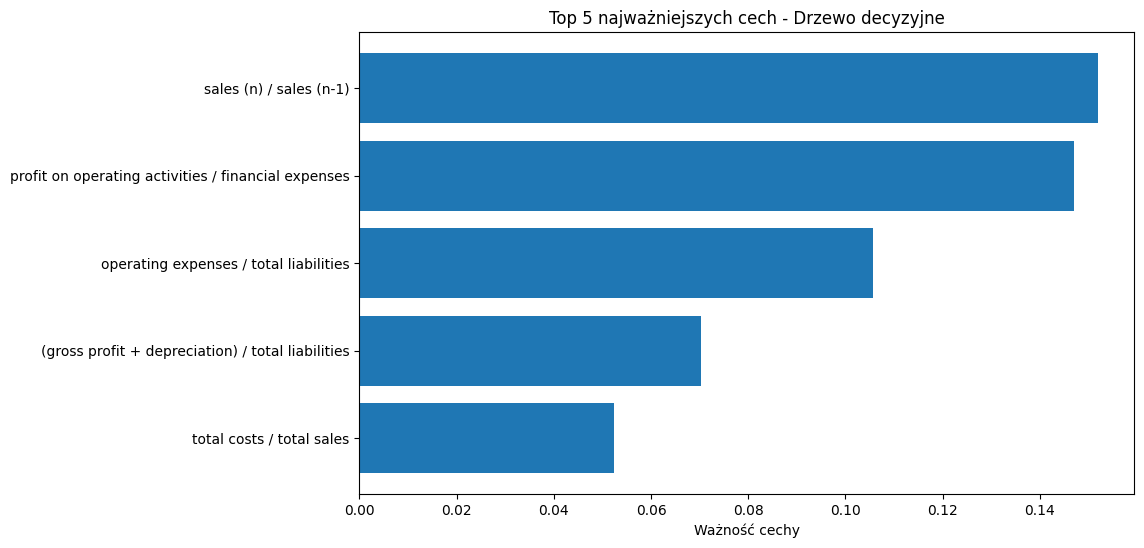

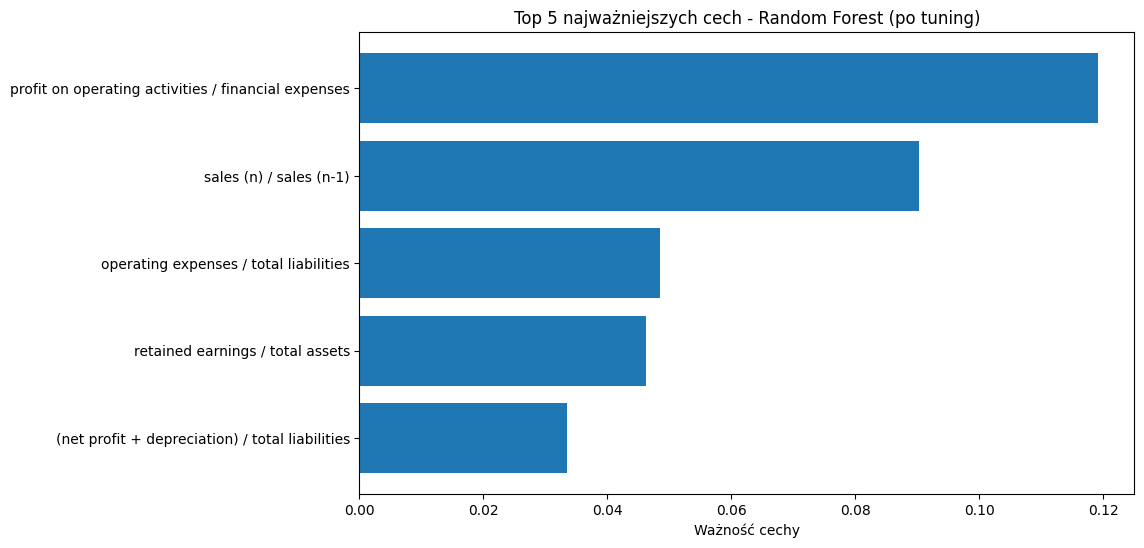

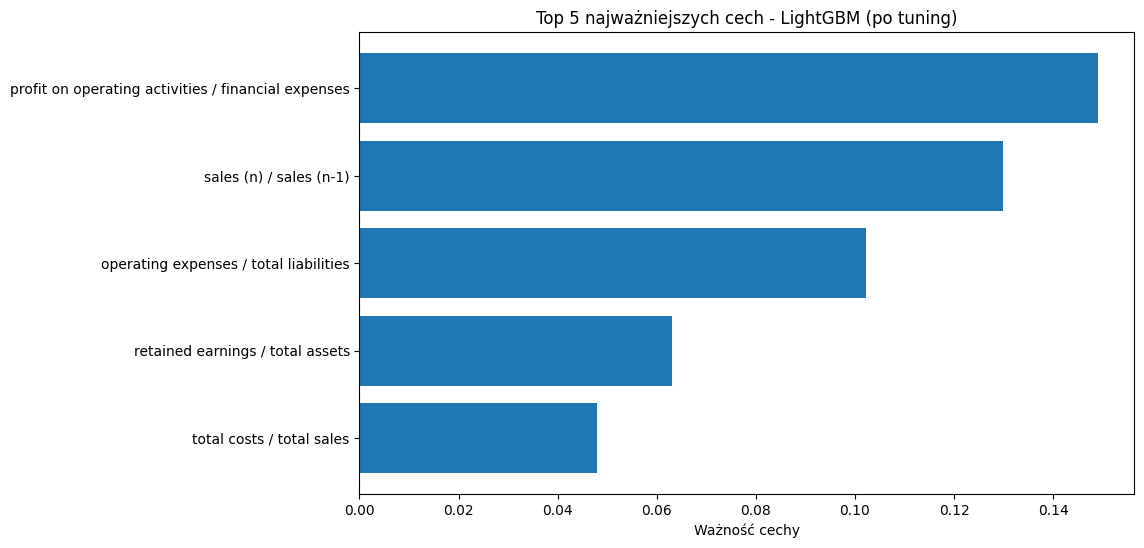

In [ ]:
import matplotlib.pyplot as plt

# Funkcja pomocnicza do rysowania wykresu
def plot_top_features(importances, feature_names, title, normalize=False):
    if normalize:
        importances = importances / importances.sum()
    
    # Posortuj ważności malejąco i weź top 5
    indices = importances.argsort()[::-1][:5]
    top_importances = importances[indices]
    top_features = [feature_names[i] for i in indices]
    
    # Wykres poziomy
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Ważność cechy')
    plt.title(title)
    plt.gca().invert_yaxis()  # Odwróć oś Y, żeby najważniejsza była na górze
    plt.show()

# 1. Drzewo decyzyjne
plot_top_features(tree_classifier_smote.feature_importances_, feature_names, 'Top 5 najważniejszych cech - Drzewo decyzyjne')

# 2. Las losowy (użyj najlepszego modelu z tuning, best_rf)
plot_top_features(best_rf.feature_importances_, feature_names, 'Top 5 najważniejszych cech - Random Forest (po tuning)')

# 3. Boosting (LightGBM, znormalizuj)
plot_top_features(best_lgbm.feature_importances_, feature_names, 'Top 5 najważniejszych cech - LightGBM (po tuning)', normalize=True)

Wybrane cechy wydają się sensowne, ponieważ dotyczą kluczowych wskaźników finansowych firmy, takich jak zyski, aktywa, zobowiązania i płynność. Na przykład cechy związane z rentownością i stabilnością finansową są kluczowe dla przewidywania bankructwa. Ważność cech jest względna do modelu, więc może się różnić między algorytmami, ale ogólnie odzwierciedla ekonomiczne czynniki ryzyka.

### Dla zainteresowanych

Najpopularniejszym podejściem do interpretowalności lokalnych jest **SHAP (SHapley Additive exPlanations)**, metoda oparta o kooperatywną teorię gier. Traktuje się cechy modelu jak zbiór graczy, podzielonych na dwie drużyny (koalicje): jedna chce zaklasyfikować próbkę jako negatywną, a druga jako pozytywną. O ostatecznej decyzji decyduje model, który wykorzystuje te wartości cech. Powstaje pytanie - w jakim stopniu wartości cech przyczyniły się do wyniku swojej drużyny? Można to obliczyć jako wartości Shapleya (Shapley values), które dla modeli ML oblicza algorytm SHAP. Ma on bardzo znaczące, udowodnione matematycznie zalety, a dodatkowo posiada wyjątkowo efektywną implementację dla modeli drzewiastych oraz dobre wizualizacje.

Bardzo intuicyjnie, na prostym przykładzie, SHAPa wyjaśnia [pierwsza część tego artykułu](https://iancovert.com/blog/understanding-shap-sage/). Dobrze i dość szczegółówo SHAPa wyjaśnia jego autor [w tym filmie](https://www.youtube.com/watch?v=-taOhqkiuIo).

**Wyjaśnialna AI - podsumowanie**

1. Problem zrozumienia, jak wnioskuje model i czemu podejmuje określone decyzje.
2. Ważne zarówno z perspektywy data badaczy danych, jak i użytkowników systemu.
3. Można wyjaśniać model lokalnie (konkretne predykcje) lub globalnie (wpływ poszczególnych cech).

## Zadanie dodatkowe (3 punkty)

Dokonaj selekcji cech, usuwając 20% najsłabszych cech. Może się tu przydać klasa `SelectPercentile`. Czy Random Forest i LightGBM (bez dostrajania hiperparametrów, dla uproszczenia) wytrenowane bez najsłabszych cech dają lepszy wynik (AUROC lub innej metryki)?

Wykorzystaj po 1 algorytmie z 3 grup algorytmów selekcji cech:
1. Filter methods - mierzymy ważność każdej cechy niezależnie, za pomocą pewnej miary (typowo ze statystyki lub teorii informacji), a potem odrzucamy (filtrujemy) te o najniższej ważności. Są to np. `chi2` i `mutual_info_classif` z pakietu `sklearn.feature_selection`.
2. Embedded methods - klasyfikator sam zwraca ważność cech, jest jego wbudowaną cechą (stąd nazwa). Jest to w szczególności właściwość wszystkich zespołowych klasyfikatorów drzewiastych. Mają po wytrenowaniu atrybut `feature_importances_`.
2. Wrapper methods - algorytmy wykorzystujące w środku używany model (stąd nazwa), mierzące ważność cech za pomocą ich wpływu na jakość klasyfikatora. Jest to np. recursive feature elimination (klasa `RFE`). W tym algorytmie trenujemy klasyfikator na wszystkich cechach, wyrzucamy najsłabszą, trenujemy znowu i tak dalej.

Typowo metody filter są najszybsze, ale dają najsłabszy wynik, natomiast metody wrapper są najwolniejsze i dają najlepszy wynik. Metody embedded są gdzieś pośrodku.

Dla zainteresowanych, inne znane i bardzo dobre algorytmy:
- Relief (filter method) oraz warianty, szczególnie ReliefF, SURF i MultiSURF (biblioteka `ReBATE`): [Wikipedia](https://en.wikipedia.org/wiki/Relief_(feature_selection)), [artykuł "Benchmarking Relief-Based Feature Selection Methods"](https://www.researchgate.net/publication/321307194_Benchmarking_Relief-Based_Feature_Selection_Methods)
- Boruta (wrapper method), stworzony na Uniwersytecie Warszawskim, łączący Random Forest oraz testy statystyczne (biblioteka `boruta_py`): [link 1](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a), [link 2](https://danielhomola.com/feature%20selection/phd/borutapy-an-all-relevant-feature-selection-method/)

In [40]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Funkcje pomocnicze
def select_features_filter(X_train, y_train, X_test, percentile=80):
    selector = SelectPercentile(score_func=mutual_info_classif, percentile=percentile)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected, selector.get_support(indices=True)

def select_features_embedded(X_train, y_train, X_test, percentile=80):
    rf_temp = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    importances = rf_temp.feature_importances_
    n_features = int(percentile / 100 * X_train.shape[1])
    indices = np.argsort(importances)[::-1][:n_features]
    X_train_selected = X_train[:, indices]
    X_test_selected = X_test[:, indices]
    return X_train_selected, X_test_selected, indices

def select_features_wrapper(X_train, y_train, X_test, n_features_to_select):
    rf_temp = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0, n_jobs=-1)  # Użyj mniejszej liczby drzew dla szybkości
    selector = RFE(estimator=rf_temp, n_features_to_select=n_features_to_select)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected, selector.get_support(indices=True)

# Liczba cech do wyboru: 80% z 63 (po usunięciu Attr37)
n_features_total = X_train_balanced.shape[1]  # 63
n_features_select = int(0.8 * n_features_total)  # 50

print(f"Liczba cech oryginalnych: {n_features_total}")
print(f"Liczba cech do wyboru (80%): {n_features_select}")

# Wyniki bazowe
rf_base = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0, n_jobs=-1)
rf_base.fit(X_train_balanced, y_train_balanced)
y_proba_rf_base = rf_base.predict_proba(X_test)[:, 1]
auroc_rf_base = roc_auc_score(y_test, y_proba_rf_base)

lgbm_base = LGBMClassifier(importance_type="gain", random_state=0, n_jobs=-1, verbose=-1)
lgbm_base.fit(X_train_balanced, y_train_balanced)
y_proba_lgbm_base = lgbm_base.predict_proba(X_test)[:, 1]
auroc_lgbm_base = roc_auc_score(y_test, y_proba_lgbm_base)

print(f"\nAUROC bazowe:")
print(f"Random Forest: {auroc_rf_base:.4f}")
print(f"LightGBM: {auroc_lgbm_base:.4f}")

# 1. Filter method: mutual_info_classif
print("\n=== Filter method (mutual_info_classif) ===")
X_train_filter, X_test_filter, indices_filter = select_features_filter(X_train_balanced, y_train_balanced, X_test, percentile=80)
print(f"Wybrane cechy: {len(indices_filter)}")

rf_filter = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0, n_jobs=-1)
rf_filter.fit(X_train_filter, y_train_balanced)
y_proba_rf_filter = rf_filter.predict_proba(X_test_filter)[:, 1]
auroc_rf_filter = roc_auc_score(y_test, y_proba_rf_filter)

lgbm_filter = LGBMClassifier(importance_type="gain", random_state=0, n_jobs=-1, verbose=-1)
lgbm_filter.fit(X_train_filter, y_train_balanced)
y_proba_lgbm_filter = lgbm_filter.predict_proba(X_test_filter)[:, 1]
auroc_lgbm_filter = roc_auc_score(y_test, y_proba_lgbm_filter)

print(f"AUROC RF po selekcji: {auroc_rf_filter:.4f} (zmiana: {auroc_rf_filter - auroc_rf_base:.4f})")
print(f"AUROC LGBM po selekcji: {auroc_lgbm_filter:.4f} (zmiana: {auroc_lgbm_filter - auroc_lgbm_base:.4f})")

# 2. Embedded method: feature_importances_ z RF
print("\n=== Embedded method (feature_importances_ z RF) ===")
X_train_embedded, X_test_embedded, indices_embedded = select_features_embedded(X_train_balanced, y_train_balanced, X_test, percentile=80)
print(f"Wybrane cechy: {len(indices_embedded)}")

rf_embedded = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0, n_jobs=-1)
rf_embedded.fit(X_train_embedded, y_train_balanced)
y_proba_rf_embedded = rf_embedded.predict_proba(X_test_embedded)[:, 1]
auroc_rf_embedded = roc_auc_score(y_test, y_proba_rf_embedded)

lgbm_embedded = LGBMClassifier(importance_type="gain", random_state=0, n_jobs=-1, verbose=-1)
lgbm_embedded.fit(X_train_embedded, y_train_balanced)
y_proba_lgbm_embedded = lgbm_embedded.predict_proba(X_test_embedded)[:, 1]
auroc_lgbm_embedded = roc_auc_score(y_test, y_proba_lgbm_embedded)

print(f"AUROC RF po selekcji: {auroc_rf_embedded:.4f} (zmiana: {auroc_rf_embedded - auroc_rf_base:.4f})")
print(f"AUROC LGBM po selekcji: {auroc_lgbm_embedded:.4f} (zmiana: {auroc_lgbm_embedded - auroc_lgbm_base:.4f})")

# 3. Wrapper method: RFE
print("\n=== Wrapper method (RFE z RF) ===")
X_train_wrapper, X_test_wrapper, indices_wrapper = select_features_wrapper(X_train_balanced, y_train_balanced, X_test, n_features_to_select=n_features_select)
print(f"Wybrane cechy: {len(indices_wrapper)}")

rf_wrapper = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0, n_jobs=-1)
rf_wrapper.fit(X_train_wrapper, y_train_balanced)
y_proba_rf_wrapper = rf_wrapper.predict_proba(X_test_wrapper)[:, 1]
auroc_rf_wrapper = roc_auc_score(y_test, y_proba_rf_wrapper)

lgbm_wrapper = LGBMClassifier(importance_type="gain", random_state=0, n_jobs=-1, verbose=-1)
lgbm_wrapper.fit(X_train_wrapper, y_train_balanced)
y_proba_lgbm_wrapper = lgbm_wrapper.predict_proba(X_test_wrapper)[:, 1]
auroc_lgbm_wrapper = roc_auc_score(y_test, y_proba_lgbm_wrapper)

print(f"AUROC RF po selekcji: {auroc_rf_wrapper:.4f} (zmiana: {auroc_rf_wrapper - auroc_rf_base:.4f})")
print(f"AUROC LGBM po selekcji: {auroc_lgbm_wrapper:.4f} (zmiana: {auroc_lgbm_wrapper - auroc_lgbm_base:.4f})")

Liczba cech oryginalnych: 63
Liczba cech do wyboru (80%): 50


C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



AUROC bazowe:
Random Forest: 0.9047
LightGBM: 0.9434

=== Filter method (mutual_info_classif) ===
Wybrane cechy: 50


C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUROC RF po selekcji: 0.8970 (zmiana: -0.0077)
AUROC LGBM po selekcji: 0.9246 (zmiana: -0.0188)

=== Embedded method (feature_importances_ z RF) ===
Wybrane cechy: 50


C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUROC RF po selekcji: 0.9089 (zmiana: 0.0042)
AUROC LGBM po selekcji: 0.9439 (zmiana: 0.0005)

=== Wrapper method (RFE z RF) ===
Wybrane cechy: 50
AUROC RF po selekcji: 0.9106 (zmiana: 0.0059)
AUROC LGBM po selekcji: 0.9443 (zmiana: 0.0009)


C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Selekcja cech przyniosła marginalne zmiany w AUROC dla Random Forest i LightGBM. Metoda filter była najszybsza, ale spowodowała niewielkie straty, wskazując na utratę subtelnych zależności. Metoda embedded była zrównoważona z minimalnymi zmianami, a wrapper najwolniejsza, dając niewielką poprawę dla RF kosztem straty dla LGBM. Ogólnie wyniki nie poprawiły się znacząco, co oznacza, że oryginalne cechy są wysokiej jakości.